# Simple Kriging

#### Michael Pyrcz, Professor, The University of Texas at Austin 

##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

This is a tutorial for / demonstration of **Spatial Estimation with Kriging** with GeostatsPy. 

* specifically we use kriging to make estimates on a grid to display as a map.

**YouTube Lecture**: check out my lecture on [Kriging](https://youtu.be/CVkmuwF8cJ8?si=TzwmoF7QtppoITOv). For your convenience here's a summary of salient points.

Kriging is the geostatistical workhorse for:

1. Prediction away from wells, e.g. pre-sample assessments, interpolation and extrapolation.
2. Spatial cross validation.
3. Spatial uncertainty modeling.

First let's explain the concept of spatial estimation.

#### Spatial Estimation

Consider the case of making an estimate at some unsampled location, $𝑧(\bf{u}_0)$, where $z$ is the property of interest (e.g. porosity etc.) and $𝐮_0$ is a location vector describing the unsampled location.

How would you do this given data, $𝑧(\bf{𝐮}_1)$, $𝑧(\bf{𝐮}_2)$, and $𝑧(\bf{𝐮}_3)$?

It would be natural to use a set of linear weights to formulate the estimator given the available data.

$$
z^{*}(\bf{u}) = \sum^{n}_{\alpha = 1} \lambda_{\alpha} z(\bf{u}_{\alpha})
$$

We could add an unbiasedness constraint to impose the sum of the weights equal to one.  What we will do is assign the remainder of the weight (one minus the sum of weights) to the global average; therefore, if we have no informative data we will estimate with the global average of the property of interest.

$$
z^{*}(\bf{u}) = \sum^{n}_{\alpha = 1} \lambda_{\alpha} z(\bf{u}_{\alpha}) + \left(1-\sum^{n}_{\alpha = 1} \lambda_{\alpha} \right) \overline{z}
$$

We will make a stationarity assumption, so let's assume that we are working with residuals, $y$. 

$$
y^{*}(\bf{u}) = z^{*}(\bf{u}) - \overline{z}(\bf{u})
$$

If we substitute this form into our estimator the estimator simplifies, since the mean of the residual is zero.

$$
y^{*}(\bf{u}) = \sum^{n}_{\alpha = 1} \lambda_{\alpha} y(\bf{u}_{\alpha})
$$

while satisfying the unbaisedness constraint.  

#### Kriging

Now the next question is what weights should we use?  

We could use equal weighting, $\lambda = \frac{1}{n}$, and the estimator would be the average of the local data applied for the spatial estimate. This would not be very informative.

We could assign weights considering the spatial context of the data and the estimate:

* **spatial continuity** as quantified by the variogram (and covariance function)
* **redundancy** the degree of spatial continuity between all of the available data with themselves 
* **closeness** the degree of spatial continuity between the avaiable data and the estimation location

The kriging approach accomplishes this, calculating the best linear unbiased weights for the local data to estimate at the unknown location.  The derivation of the kriging system and the resulting linear set of equations is available in the lecture notes.  Furthermore kriging provides a measure of the accuracy of the estimate!  This is the kriging estimation variance (sometimes just called the kriging variance).

$$
\sigma^{2}_{E}(\bf{u}) = C(0) - \sum^{n}_{\alpha = 1} \lambda_{\alpha} C(\bf{u}_0 - \bf{u}_{\alpha})
$$

What is 'best' about this estimate? Kriging estimates are best in that they minimize the above estimation variance. 

#### Properties of Kriging

Here are some important properties of kriging:

* **Exact interpolator** - kriging estimates with the data values at the data locations
* **Kriging variance** can be calculated before getting the sample information, as the kriging estimation variance is not dependent on the values of the data nor the kriging estimate, i.e. the kriging estimator is homoscedastic. 
* **Spatial context** - kriging takes into account, furthermore to the statements on spatial continuity, closeness and redundancy we can state that kriging accounts for the configuration of the data and structural continuity of the variable being estimated.
* **Scale** - kriging may be generalized to account for the support volume of the data and estimate. We will cover this later.
* **Multivariate** - kriging may be generalized to account for multiple secondary data in the spatial estimate with the cokriging system. We will cover this later.
* **Smoothing effect** of kriging can be forecast. We will use this to build stochastic simulations later.

#### Load the required libraries

The following code loads the required libraries.

In [1]:
import geostatspy.GSLIB as GSLIB                              # GSLIB utilies, visualization and wrapper
import geostatspy.geostats as geostats                        # GSLIB methods convert to Python      
import geostatspy
print('GeostatsPy version: ' + str(geostatspy.__version__))  

GeostatsPy version: 0.0.71


We will also need some standard packages. These should have been installed with Anaconda 3.

In [2]:
import os                                                     # set working directory, run executables

from tqdm import tqdm                                         # supress the status bar
from functools import partialmethod
tqdm.__init__ = partialmethod(tqdm.__init__, disable=True)

ignore_warnings = True                                        # ignore warnings?
import numpy as np                                            # ndarrys for gridded data
import pandas as pd                                           # DataFrames for tabular data
import matplotlib.pyplot as plt                               # for plotting
plt.rc('axes', axisbelow=True)                                # plot all grids below the plot elements
if ignore_warnings == True:                                   
    import warnings
    warnings.filterwarnings('ignore')
cmap = plt.cm.inferno                                         # color map

If you get a package import error, you may have to first install some of these packages. This can usually be accomplished by opening up a command window on Windows and then typing 'python -m pip install [package-name]'. More assistance is available with the respective package docs.

#### Set the working directory

I always like to do this so I don't lose files and to simplify subsequent read and writes (avoid including the full address each time). 

In [3]:
#os.chdir("d:/PGE383")                                        # set the working directory

#### Loading Tabular Data

Here's the command to load our comma delimited data file in to a Pandas' DataFrame object. 

* note the "fraction_data" variable is an option to random take part of the data (i.e., 1.0 is all data).

    * this is not standard part of spatial estimation, but fewer data is easier to visualize given our grid size (we want multiple cells between the data to see the behavoir away from data)

* note, I often remove unnecessary data table columns. This clarifies workflows and reduces the chance of blunders, e.g., using the wrong column!

In [4]:
fraction_data = 0.2                                           # extract a fraction of data for demonstration / faster runs, set to 1.0 for homework

df = pd.read_csv("https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/sample_data_MV_biased.csv") # load the data from Dr. Pyrcz's GitHub repository

if fraction_data < 1.0:
    df = df.sample(frac = fraction_data,replace = False,random_state = 73073) # random sample from the dataset
df = df.reset_index()                                         # reorder the data index
df = df.iloc[:,2:7]                                           # remove the unneeded features, columns

df['LogPerm'] = np.log(df['Perm'].values)                     # apply the log transform to remove skew from permeability

df.head()                                                     # preview the DataFrame

,X,Y,Facies,Porosity,Perm,LogPerm
0,280.0,409.0,1.0,0.136716,17.126888,2.840650
1,230.0,749.0,1.0,0.204587,1665.384124,7.417811
2,300.0,500.0,1.0,0.159891,105.797436,4.661526
3,620.0,389.0,0.0,0.100296,7.578784,2.025353
4,370.0,689.0,1.0,0.142434,218.419949,5.386420


#### Summary Statistics

Let's look at summary statistics for all facies combined:

In [5]:
df.describe().transpose()                                     # summary table of all facies combined DataFrame statistics

,count,mean,std,min,25%,50%,75%,max
X,74.0,471.891892,282.603724,0.000000,232.500000,405.000000,765.000000,990.000000
Y,74.0,489.932432,291.512933,9.000000,224.000000,484.500000,729.000000,999.000000
Facies,74.0,0.594595,0.494322,0.000000,0.000000,1.000000,1.000000,1.000000
Porosity,74.0,0.125834,0.031093,0.062169,0.102895,0.126264,0.148840,0.204587
Perm,74.0,73.040451,214.164084,0.300430,2.081215,10.385010,50.841029,1665.384124
LogPerm,74.0,2.358329,2.086617,-1.202542,0.731083,2.339396,3.928694,7.417811


Let's also look at the distributions.  

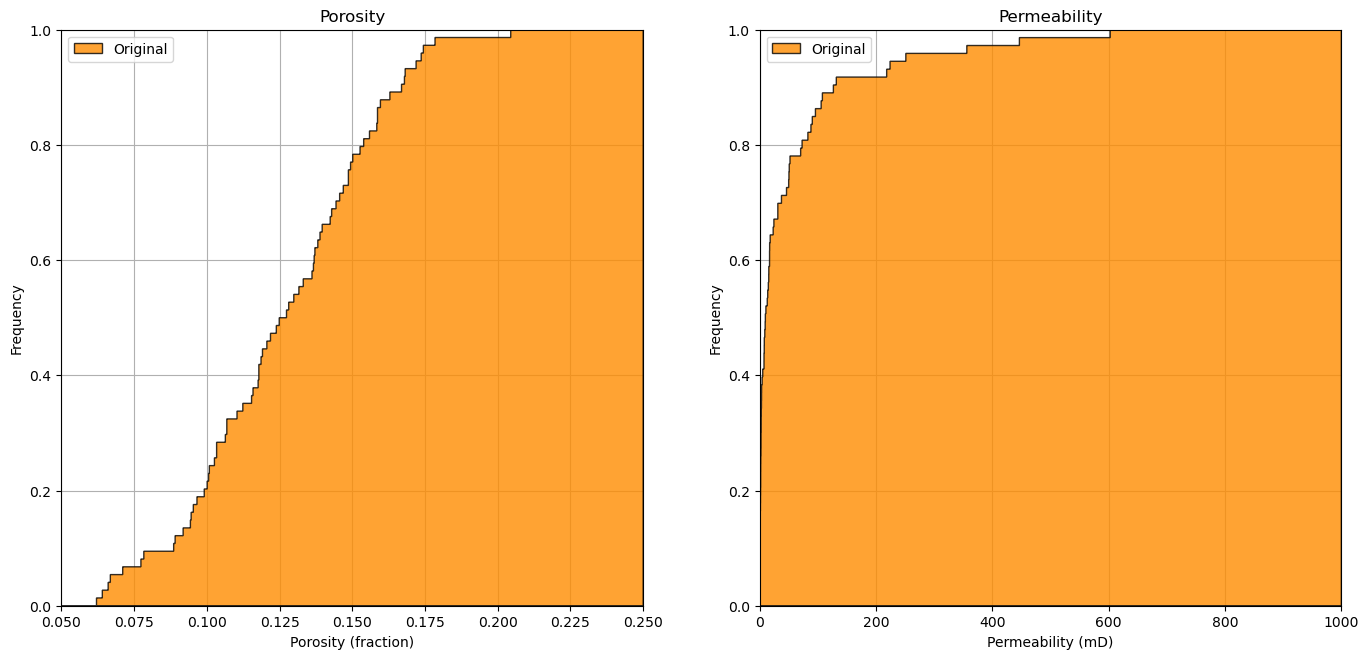

In [6]:
plt.subplot(121)                                              # plot original sand and shale porosity histograms
plt.hist(df['Porosity'], facecolor='darkorange',bins=np.linspace(0.0,0.25,1000),histtype="stepfilled",alpha=0.8,density=True,cumulative=True,edgecolor='black',label='Original')
plt.xlim([0.05,0.25]); plt.ylim([0,1.0])
plt.xlabel('Porosity (fraction)'); plt.ylabel('Frequency'); plt.title('Porosity')
plt.legend(loc='upper left')
plt.grid(True)

plt.subplot(122)                                               # plot nscore transformed sand and shale histograms
plt.hist(df['Perm'], facecolor='darkorange',bins=np.linspace(0.0,1000.0,100000),histtype="stepfilled",alpha=0.8,density=True,cumulative=True,edgecolor='black',label='Original')
plt.xlim([0.0,1000.0]); plt.ylim([0,1.0])
plt.xlabel('Permeability (mD)'); plt.ylabel('Frequency'); plt.title('Permeability')
plt.legend(loc='upper left')
plt.grid(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.3)
plt.show()

We observe from the CDFs that the porosity distribution is 'Gaussian-like' in shape, while the permeability distribution is 'lognormal-like'. They both look well behaved.

#### Calculating the Representative Mean with Declustering

For brevity we omit data inference from this workflow:

1. declustering for the representative distribution and statistics
2. variogram calculation and modeling spatial continuity

Instead we:

* assume the declustered means for the porosity and permeability to apply with simple kriging.

* change the variogram models to observe the impact on simple kriging. 

##### Specify the Grid

Let's specify a reasonable grid to the estimation map.

* we balance detail and computation time. Note kriging computation complexity scales $O(n_{cell})$

* so if we half the cell size we have 4 times more grid cells in 2D, 4 times the runtime

In [7]:
xmin = 0.0; xmax = 1000.0                                     # range of x values
ymin = 0.0; ymax = 1000.0                                     # range of y values

xsiz = 10; ysiz = 10                                          # cell size
nx = 100; ny = 100                                            # number of cells
xmn = 5; ymn = 5                                              # grid origin, location center of lower left cell

pormin = 0.05; pormax = 0.22                                  # set feature min and max for colorbars
permmin = 0.0; permmax = 700.0

##### Location Maps

Let's plot the location maps of porosity and permeability for all facies. We will also include a cross plot of permeability vs. porosity colored by facies to aid with comparison in spatial features between the porosity and permeability data.

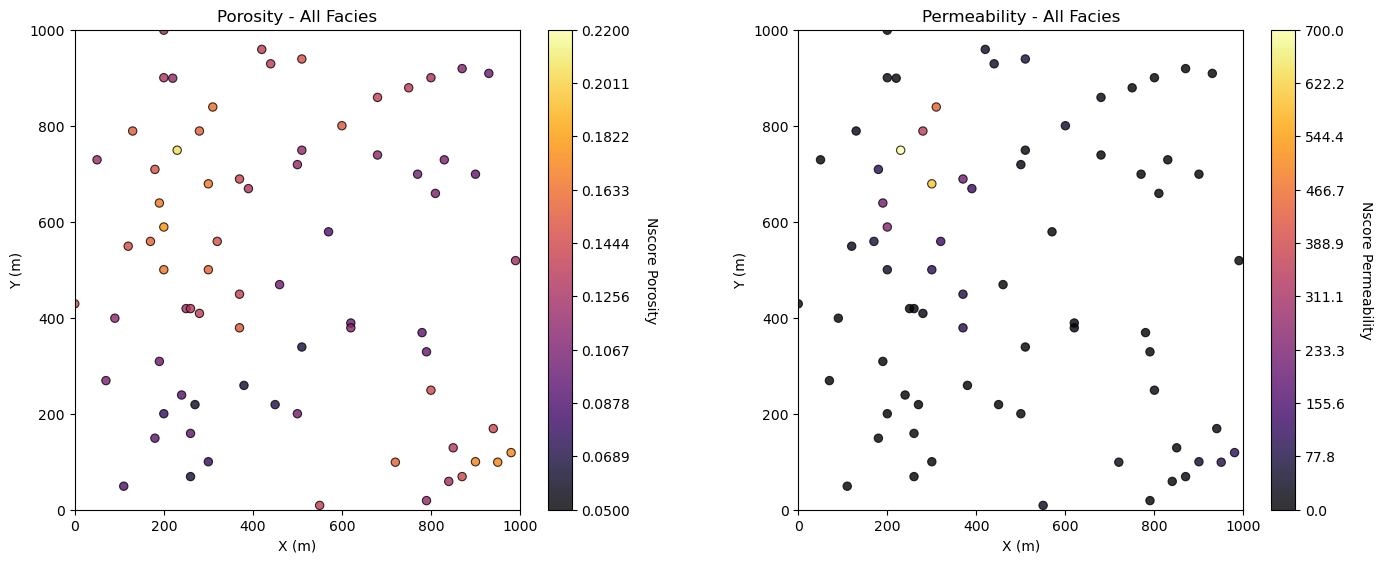

In [8]:
plt.subplot(121)
GSLIB.locmap_st(df,'X','Y','Porosity',0,1000,0,1000,pormin,pormax,'Porosity - All Facies','X (m)','Y (m)','Nscore Porosity',cmap)

plt.subplot(122)
GSLIB.locmap_st(df,'X','Y','Perm',0,1000,0,1000,permmin,permmax,'Permeability - All Facies','X (m)','Y (m)','Nscore Permeability',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.3, hspace=0.3); plt.show()

#### Kriging for Porosity and Permeability Maps

Now let's try some kriging with the continuous properties. For this workflow we will demonstrate a cookie-cutter approach.  The steps are:

1. model the facies, sand and shale, probabilities with indicator kriging
2. model the porosity for sand and shale separately and exhaustively, i.e. at all locations in the model
3. model the permeability for sand and shale separately and exhaustively, i.e. at all locations in the model
4. assign sand and shale locations based on the probabilities from step 1 
5. combine the porosity and permeability from sand and shale regions together

Limitations of this Workflow:

* kriging is too smooth, the spatial continuity is too high
* kriging does not reproduce the continuous property distributions
* we are not accounting for the correlation between porosity and permeability 

We will correct these issues when we perform simulation later.

##### Simple Kriging Estimation Map of Porosity

Let's specify the variogram model, global stationary mean and variance, and kriging parameters.

In [9]:
%%capture --no-display                                                                

por_vrange_maj = 250; por_vrange_min = 100                    # variogram ranges
por_vazi = 150.0                                              # variogram major direction
por_vrel_nugget = 0.0                                         # variogram nugget effect

por_skmean = np.average(df['Porosity'].values)                # assume global mean is the mean of the sample
por_sill = np.var(df['Porosity'].values)                      # assume sill is variance of the sample

por_vario = GSLIB.make_variogram(nug=por_vrel_nugget*por_sill,nst=1,it1=1,cc1=(1.0-por_vrel_nugget)*por_sill,
         azi1=por_vazi,hmaj1=por_vrange_maj,hmin1=por_vrange_min) # porosity variogram

ktype = 0                                                     # kriging type, 0 - simple, 1 - ordinary
radius = 600                                                  # search radius for neighbouring data
nxdis = 1; nydis = 1                                          # number of grid discretizations for block kriging
ndmin = 0; ndmax = 10                                         # minimum and maximum data for an estimate

Now let's pass this to kriging to make our porosity kriging estimate map.

  Estimated   10000 blocks 
      average   0.12433154498291114  variance  0.00036429504237079496


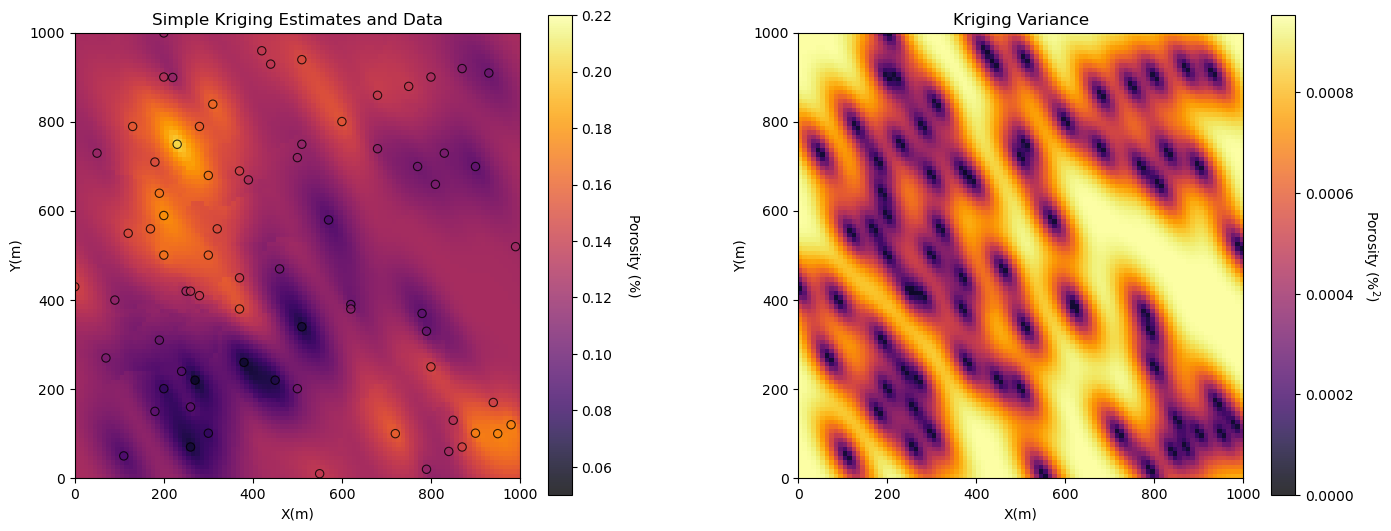

In [10]:
por_kmap, por_vmap = geostats.kb2d(df,'X','Y','Porosity',pormin,pormax,nx,xmn,xsiz,ny,ymn,ysiz,nxdis,nydis,
         ndmin,ndmax,radius,ktype,por_skmean,por_vario)

plt.subplot(121)
GSLIB.locpix_st(por_kmap,xmin,xmax,ymin,ymax,xsiz,pormin,pormax,df,'X','Y','Porosity','Simple Kriging Estimates and Data','X(m)','Y(m)','Porosity (%)',cmap)

plt.subplot(122)
GSLIB.pixelplt_st(por_vmap,xmin,xmax,ymin,ymax,xsiz,0.0,por_sill,'Kriging Variance','X(m)','Y(m)',r'Porosity ($\%^2$)',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.3, hspace=0.3); plt.show()

Some observations for simple kriging:

* **Smooth Estimates** - see the smooth kriging estimates

* **Estimate the Global Mean** - estimated values at distance greater than the variogram range from any data approach the global mean. 

* **Exactitiude** - estimate the data values with 0.0 estimation variance at data locations.

* **Variogram Model** - see the kriging estimation and variance map and observe the impact of variogram range and potential anisotropy.

* **Search Artifacts** - you may see artifacts, arcs or rays with sharp changes in estimates or estimation variance.

#### Simple Kriging Estimation Map of Permeability

Now let's calculate the kriging estimation map for permeability

* note, due to the strong positive skew of permeability and the kriging screening effect, permeability estimates may be very small or even negative. We truncate the map to clean this up

* we will apply the log transformation to improve the visualization. We could also plot in log scale, but this is not very convenient with MatPlotLib. 

Note, there is the potential issues when modeling log transformed permeability.

* this includes invalidating model assumptions, such as homoscedastic error, and also reduced interpretability

* so we only apply log transform for visualization, the actual model is in the original permeability feature

Let's specify the variogram model, global stationary mean and variance, and kriging parameters.

In [11]:
%%capture --no-display     

perm_vrange_maj = 250; perm_vrange_min = 100                  # variogram ranges
perm_vazi = 150.0                                             # variogram major direction
perm_vrel_nugget = 0.0                                        # variogram nugget effect

perm_skmean = np.average(df['Perm'].values)                   # assume global mean is the mean of the sample
perm_sill = np.var(df['Perm'].values)                         # assume sill is variance of the sample

perm_vario = GSLIB.make_variogram(nug=perm_vrel_nugget*perm_sill,nst=1,it1=1,cc1=(1.0-perm_vrel_nugget)*perm_sill,
         azi1=perm_vazi,hmaj1=perm_vrange_maj,hmin1=perm_vrange_min) # permeability variogram

ktype = 0                                                     # kriging type, 0 - simple, 1 - ordinary
radius = 600                                                  # search radius for neighbouring data
nxdis = 1; nydis = 1                                          # number of grid discretizations for block kriging
ndmin = 0; ndmax = 10                                         # minimum and maximum data for an estimate

Now let's pass this to kriging to make our permeability kriging estimate map.

  Estimated   10000 blocks 
      average   59.28823141754682  variance  4397.711895278414


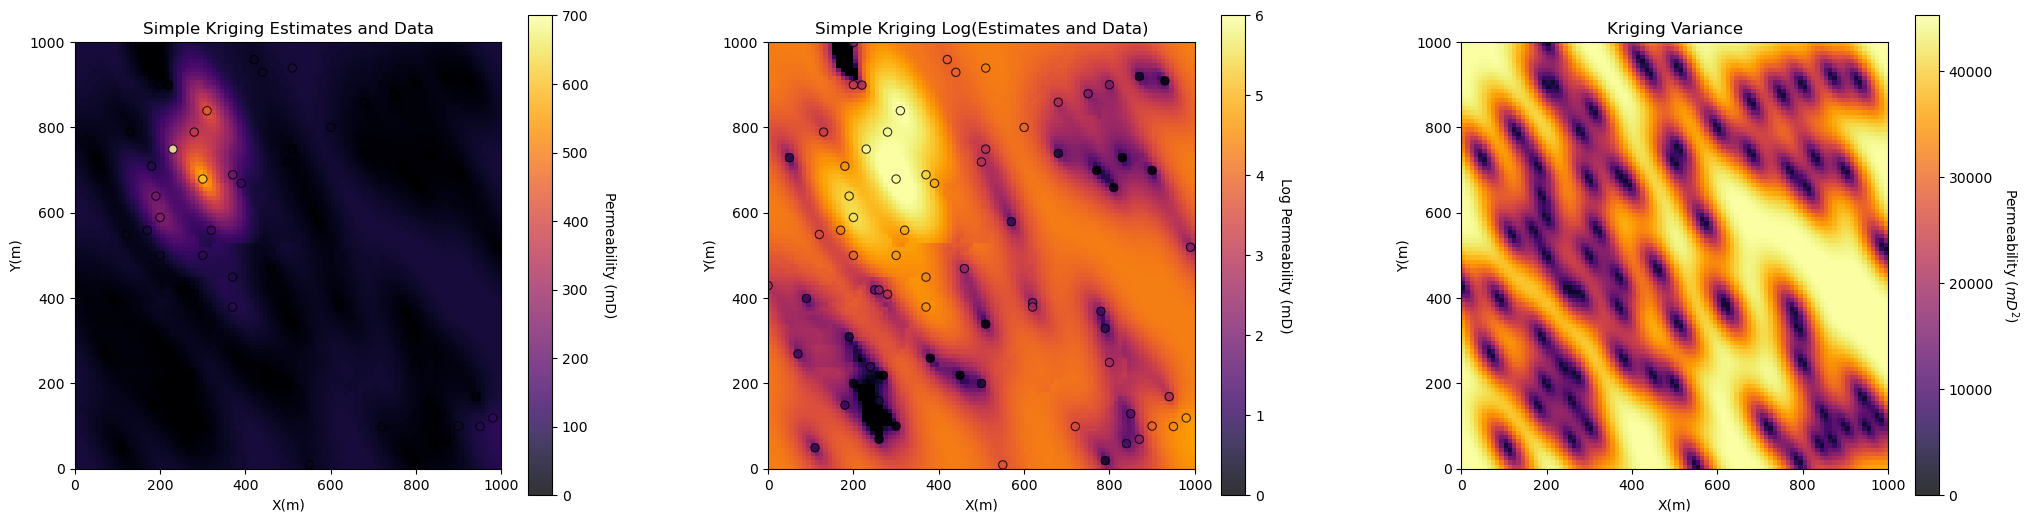

In [12]:
perm_kmap, perm_vmap = geostats.kb2d(df,'X','Y','Perm',permmin,permmax,nx,xmn,xsiz,ny,ymn,ysiz,nxdis,nydis,
          ndmin,ndmax,radius,ktype,perm_skmean,perm_vario)

perm_kmap[perm_kmap < 0.0001] = 0.0001                        # remove small and negative values due to strong positive skew and negative kriging weights

plt.subplot(131)
GSLIB.locpix_st(perm_kmap,xmin,xmax,ymin,ymax,xsiz,permmin,permmax,df,'X','Y','Perm','Simple Kriging Estimates and Data','X(m)','Y(m)','Permeability (mD)',cmap)

logperm_kmap = np.log(perm_kmap)

plt.subplot(132)
GSLIB.locpix_st(logperm_kmap,xmin,xmax,ymin,ymax,xsiz,0.0,6.0,df,'X','Y','LogPerm','Simple Kriging Log(Estimates and Data)','X(m)','Y(m)','Log Permeability (mD)',cmap)

plt.subplot(133)
GSLIB.pixelplt_st(perm_vmap,xmin,xmax,ymin,ymax,xsiz,0.0,perm_sill,'Kriging Variance','X(m)','Y(m)',r'Permeability ($mD^2$)',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.0, wspace=0.3, hspace=0.3); plt.show()

#### Ordinary Kriging Estimation Map of Porosity

Let's try ordinary kriging and compare the results to simple kriging.

* we shorten the variogram model range to exagerate the difference between simple and ordinary kriging, i.e., with esitmates outside variogram range from any data

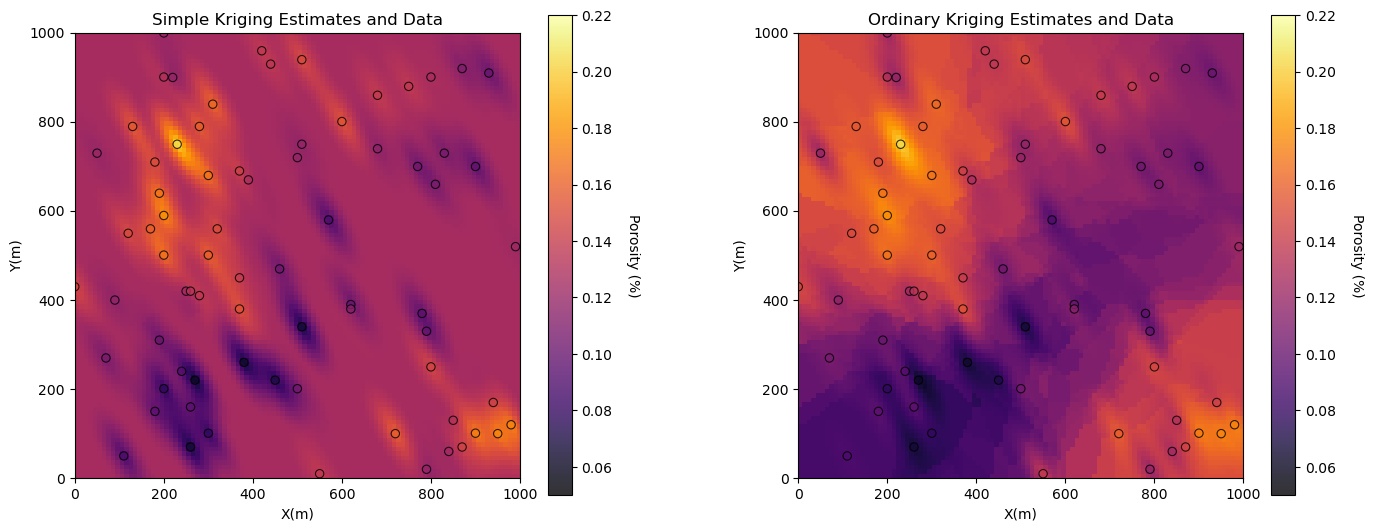

In [13]:
%%capture --no-display     

por_vrange_maj2 = 150; por_vrange_min2 = 50                   # variogram ranges
por_vazi2 = 150.0                                             # variogram major direction
por_vrel_nugget2 = 0.0                                        # variogram nugget effect

por_vario2 = GSLIB.make_variogram(nug=por_vrel_nugget2*por_sill,nst=1,it1=1,cc1=(1.0-por_vrel_nugget2)*por_sill,
         azi1=por_vazi2,hmaj1=por_vrange_maj2,hmin1=por_vrange_min2) # porosity variogram

por_SK_kmap, por_vmap = geostats.kb2d(df,'X','Y','Porosity',pormin,pormax,nx,xmn,xsiz,ny,ymn,ysiz,nxdis,nydis,
         ndmin,ndmax,radius,0,por_skmean,por_vario2)

por_OK_kmap, por_OK_vmap = geostats.kb2d(df,'X','Y','Porosity',pormin,pormax,nx,xmn,xsiz,ny,ymn,ysiz,nxdis,nydis,
         ndmin,ndmax,radius,1,por_skmean,por_vario2)

plt.subplot(121)
GSLIB.locpix_st(por_SK_kmap,xmin,xmax,ymin,ymax,xsiz,pormin,pormax,df,'X','Y','Porosity','Simple Kriging Estimates and Data','X(m)','Y(m)','Porosity (%)',cmap)

plt.subplot(122)
GSLIB.locpix_st(por_OK_kmap,xmin,xmax,ymin,ymax,xsiz,pormin,pormax,df,'X','Y','Porosity','Ordinary Kriging Estimates and Data','X(m)','Y(m)','Porosity (%)',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.3, hspace=0.3); plt.show()

#### Comments

This was a basic demonstration of kriging for spatial estimation with GeostatsPy. Much more can be done, I have other demonstrations for modeling workflows with GeostatsPy in the GitHub repository [GeostatsPy_Demos](https://github.com/GeostatsGuy/GeostatsPy_Demos/tree/main).

I hope this is helpful,

*Michael*

#### The Author:

### Michael Pyrcz, Professor, The University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PIs including Profs. Foster, Torres-Verdin and van Oort)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Professor, Cockrell School of Engineering and The Jackson School of Geosciences, The University of Texas at Austin

#### More Resources Available at: [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)  
  